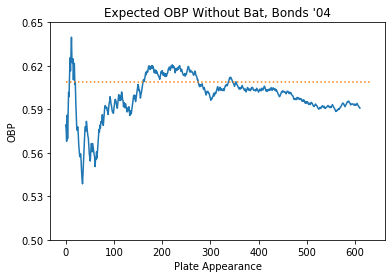

Overall OBP:  0.5908202612692495


In [2]:
import matplotlib.pyplot as mp
import os
import re

# Each file in /txts/ contains PITCH SEQUENCE (field 7) and 
#   BATTER ID (field 10) from Retrosheet's 2004 event files


# Collect every Bonds plate appearance from each file in txts
bonds = []
for filename in os.listdir('txts'):
    f = open(os.path.join('txts',filename),'r')
    ft = f.read().split()
    for i in ft:
        if (i.split(",")[1] == '"bondb001"'):
            bonds.append(i.split(",")[0].strip('""'))
    f.close()

# For each plate appearance, calculate and accumulate expected walks
expw = 0
expws = []
pa = 0
pas = list(range(len(bonds)))
obp = []
for i in range(len(bonds)):
    pw = parsePA(bonds[i])
    expw += pw
    expws.append(expw)
    obp.append(expw/(i+1))
    #print([expw,obp[i]])
    
# Plot OBP across season
mp.plot(obp[20:])
mp.plot([1,len(bonds)],[.609,.609],linestyle=':')
#mp.plot([1,len(bonds)],[.582,.582])
mp.ylim([0.50,0.65])
mp.yticks([.5,.53,.56,.59,.62,.65])
mp.title("Expected OBP Without Bat, Bonds '04")
mp.xlabel("Plate Appearance")
mp.ylabel("OBP")
mp.show()

print("Overall OBP: ",obp[-1])

In [1]:
def parsePA(sequence):
    import numpy as np
    
    np.set_printoptions(precision=3,suppress = True)
    
    # First: prepare the sequence
    #print(sequence)
    seq = re.sub("[+*.123>]","",sequence)
    for i in range(len(seq),6):
        seq += "?"
    seq = seq[:6]
    #print(seq)
        
    # Assign ball probability to each pitch
    pb = np.zeros(6)
    hbp = False
    for i in range(6):
        if seq[i] == "H" or hbp:
            pb[i] = 1
            hbp = True
        elif seq[i] in "BI":
            pb[i] = 1
        elif seq[i] in "FLSTX":
            pb[i] = 0.191
        elif seq[i] in "C":
            pb[i] = 0
        elif seq[i] in "?":
            pb[i] = 0.587
        else:
            print(seq)
            return

    # Generate count probabilities
    counts = np.zeros([5,4])
    counts[0,0] = 1
    for b in range(4):
        counts[b+1,0] = counts[b,0]*pb[b]
    for s in range(3):
        counts[0,s+1] = counts[0,s]*(1-pb[s])
    for b in range(3):
        for s in range(2):
            counts[b+1,s+1] = counts[b,s+1]*pb[b+s+1] + counts[b+1,s]*(1-pb[b+s+1])
    for b in range(3):
        counts[b+1,3] = counts[b+1,2]*(1-pb[b+3])
    for s in range(2):
        counts[4,s+1] = counts[3,s+1]*pb[s+4]
        
    #print(pb)
    #print(counts)
    
    # P(walk) = p(4-0)+p(4-1)+p(4-2)
    return sum(counts[4,:])